# Generates CESM-LE Zarr data for plotting Timeseries and Epochs
### 1. Regional Timeseries 2. Epochs

In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [7]:
clobber = True

## 0. Get the model grid and generate region mask

In [3]:
grid = pop_tools.get_grid('POP_gx1v6')
#grid

In [4]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
grid = grid.isel(nlat=lat_slice)
#grid

In [5]:
#grid.TLAT.where(grid.KMT>0).plot();

In [6]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('WAP & Atlantic', so_logic & ((grid.TLONG > 260) | (grid.TLONG < 25))),
    ('Atlantic Quadrant', so_logic & ((grid.TLONG > 270) | (grid.TLONG < 0))),  # 0 - 90 (90+180=270)
    
    # 30 to 70°W
    
    ('SW Atlantic', so_logic & ((grid.TLONG > 250) | (grid.TLONG < 30))), # 30 - 70 70+180 = 250 // 30+180 = 210
    ('AP Sector', so_logic & ((grid.TLONG > 210) | (grid.TLONG < 250))), 
    
]

# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)


# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)
#masked_area    

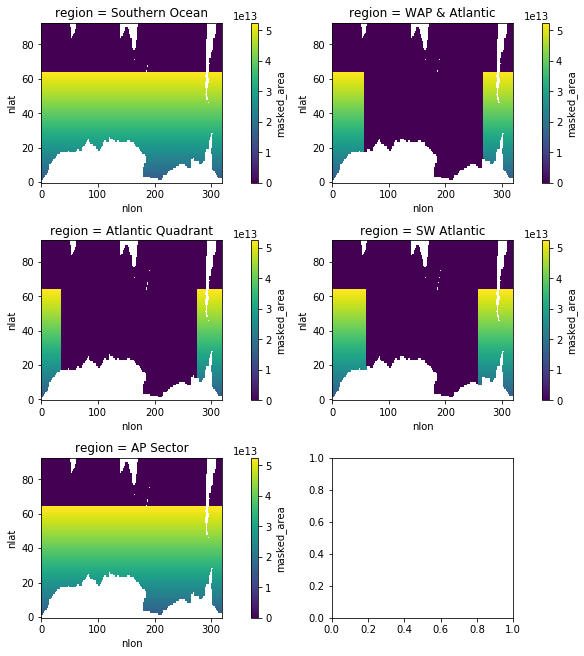

In [7]:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()    

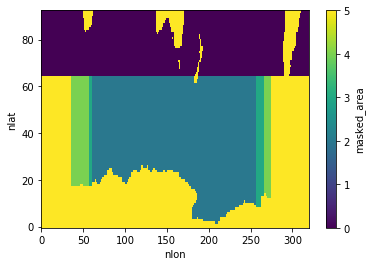

In [8]:
masked_area.where(masked_area==0).fillna(1.).sum('region').plot();

In [9]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')

In [10]:
ds_djf

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    IFRAC          (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP            (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    KGP_bias_corr  (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    NPP            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST_bias_corr  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## 1. Compute regional means // Generate a zarr file to plot

In [14]:
%%time
name = 'cesm-le-djf-triregion-timeseries-ncp'
@xp.persist_ds(name=name, format='zarr', path='data', trust_cache=True, clobber=clobber)
def regional_means():
    
    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
    
    dim = ['nlat', 'nlon']
    area_total = masked_area.sum(dim)
    weights = masked_area / area_total
    weights_sum = weights.sum(dim)

    # ensure that the weights add to 1.
    np.testing.assert_allclose(weights_sum.where(weights_sum != 0.).fillna(1.), 1.0, rtol=1e-7)

    with xr.set_options(keep_attrs=True):
        ds_djf_regional = (ds_djf[list(ds_djf.data_vars)] * weights).sum(dim).compute()

    return ds_djf_regional

ds_djf_regional = regional_means()
ds_djf_regional

writing cache file: data/cesm-le-djf-triregion-timeseries-ncp.zarr
CPU times: user 1min 23s, sys: 5min 45s, total: 7min 8s
Wall time: 7min 54s


<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, region: 5, time: 180)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * region         (region) <U17 'Southern Ocean' ... 'AP Sector'
Data variables:
    Chl_surf       (time, member_id, region) float64 0.7578 0.9736 ... 0.629
    IFRAC          (time, member_id, region) float64 0.127 0.1598 ... 0.03037
    Jint_100m_DIC  (time, member_id, region) float64 -0.02433 ... -0.0245
    KGP            (time, length, member_id, region) float64 0.02197 ... -0.01629
    KGP_bias_corr  (time, length, member_id, region) float64 0.04556 ... -0.02405
    NPP            (time, member_id, region) float64 0.05313 0.05666 ... 0.05732
    SST            (time, member_id, region) float64 4.613 4.226 ... 7.67 8.156
    SST_bias_corr  (time, member_id, region) float64 4.296 3.684 ... 6.012 6.531

## Quick Plots to check that all the files will work:

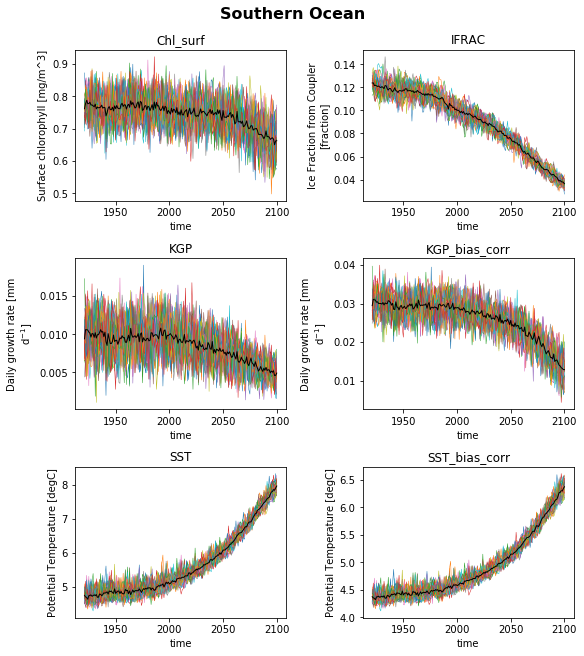

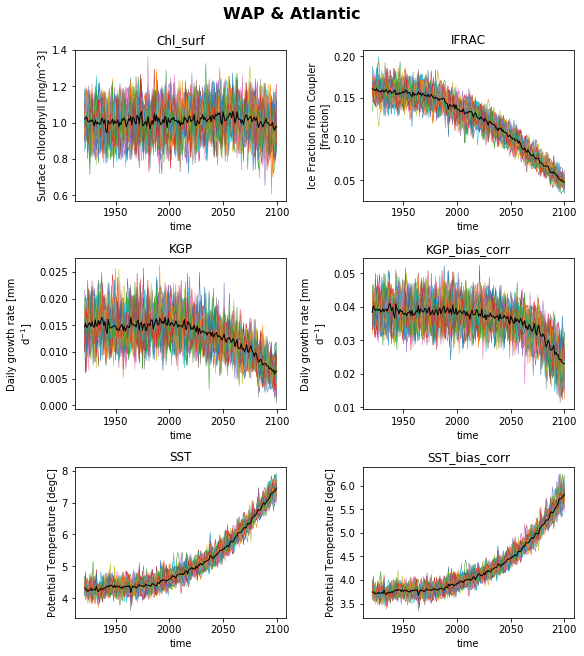

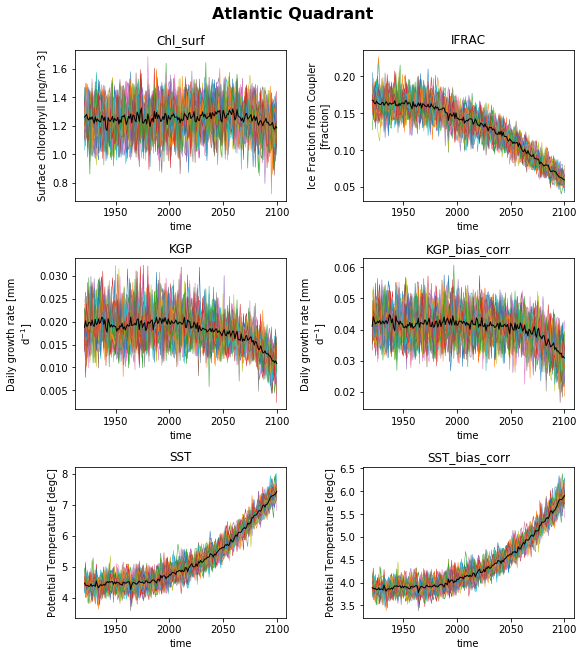

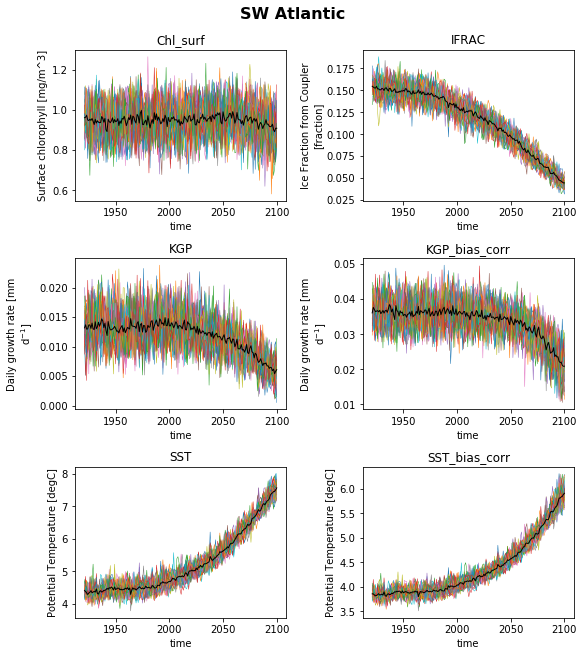

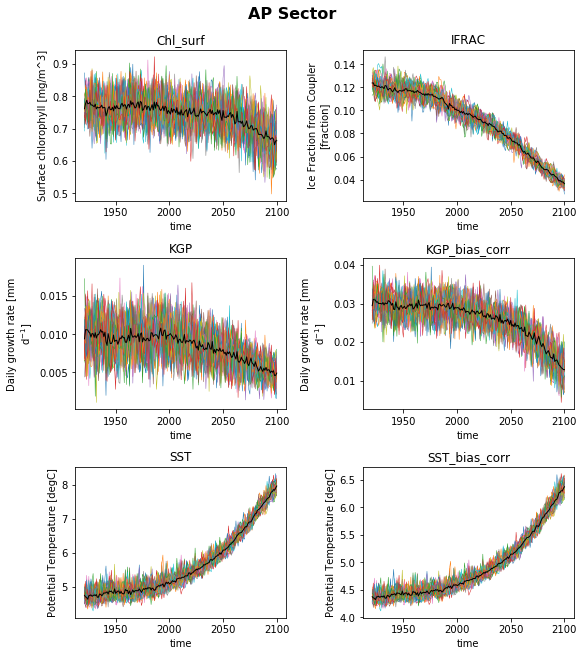

In [12]:
for plot_region in masked_area.region.values:

    nvar = len(ds_djf_regional.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, v in enumerate(ds_djf_regional.data_vars):
        plt.axes(ax.ravel()[i])

        var = ds_djf_regional[v].sel(region=plot_region)
        if 'length' in var.dims:
            var = var.sel(length=40.)            
        for m_id in ds_djf_regional.member_id:
            var_i = var.sel(member_id=m_id)
            var_i.plot(linewidth=0.5)

        with xr.set_options(keep_attrs=True):            
            var.mean('member_id').plot(color='k', linewidth=1)
        plt.title(v)
    plt.suptitle(plot_region, fontsize=16, fontweight='bold')

## 2. Generate Spatial Epoch Zarr from CESM-LE-DJF dataset
#### (of transformed data)

In [13]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    IFRAC          (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP            (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    KGP_bias_corr  (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    NPP            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST_bias_corr  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

In [16]:
%%time
name = 'cesm-le-djf-epoch-ncp'
@xp.persist_ds(name=name, format='zarr', path='data', trust_cache=True, clobber=False)
def epoch_means():
    
    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
    
    with xr.set_options(keep_attrs=True):   
        epoch_list = [
            ('1920-1950', ds_djf.sel(time=slice('1920', '1950')).mean('time')),
            #('1981-2015', ds_djf.sel(time=slice('1981', '2015')).mean('time')),
            ('2070-2100', ds_djf.sel(time=slice('2070', '2100')).mean('time')),
        ]

    epoch = xr.DataArray(
        [t[0] for t in epoch_list],
        dims=('epoch'),
        name='epoch',
    )    

    ds_djf_epoch = xr.concat(
        [t[1] for t in epoch_list], 
        dim=epoch,
    )
    return ds_djf_epoch.compute()
ds_djf_epoch = epoch_means()


writing cache file: data/cesm-le-djf-epoch-ncp.zarr
CPU times: user 14.7 s, sys: 16.5 s, total: 31.1 s
Wall time: 25.7 s


## Quick Plots to check that all the files will work:

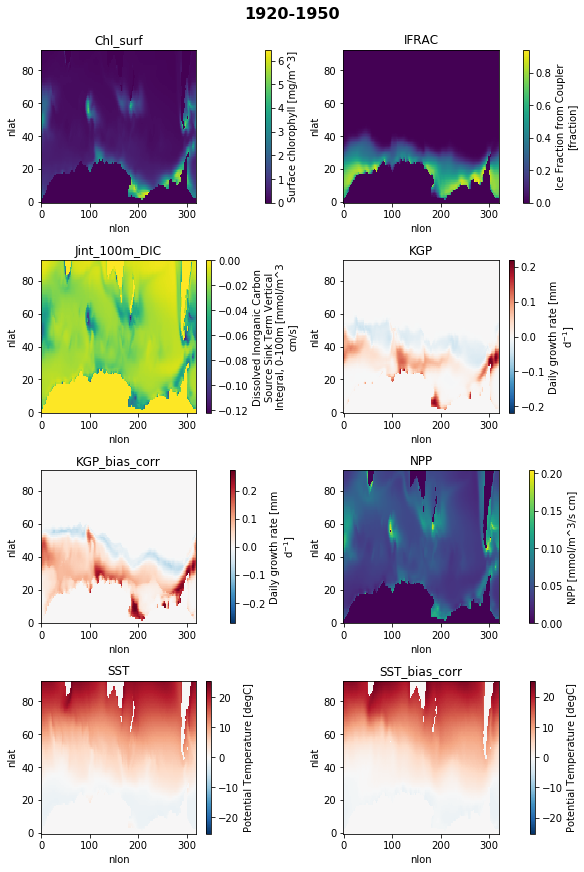

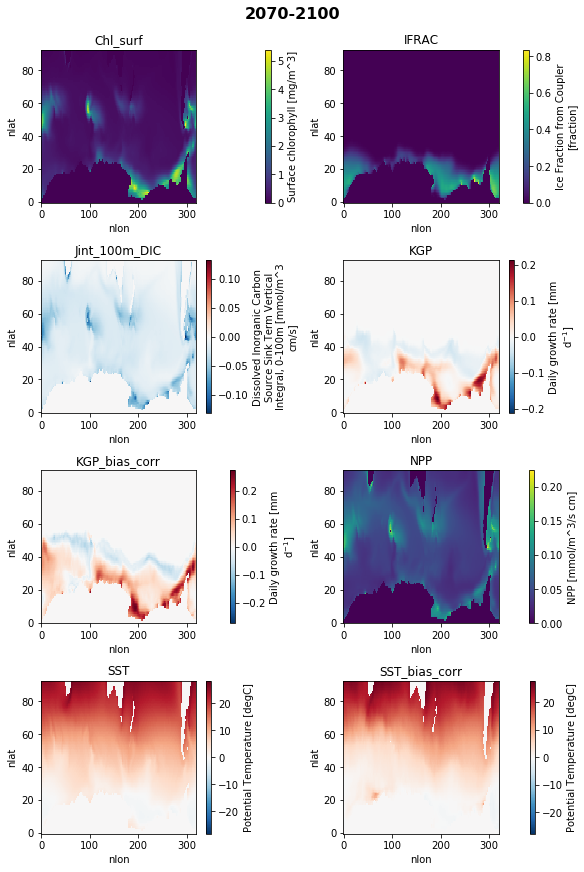

In [17]:
for epoch in ds_djf_epoch.epoch.values:

    nvar = len(ds_djf_epoch.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, v in enumerate(ds_djf_epoch.data_vars):
        plt.axes(ax.ravel()[i])

        with xr.set_options(keep_attrs=True):             
            var = ds_djf_epoch[v].sel(epoch=epoch).mean('member_id')
        if 'length' in var.dims:
            var = var.sel(length=40.)            
        var.plot()
        plt.title(v);
    plt.suptitle(epoch, fontsize=16, fontweight='bold');

In [18]:
with xr.set_options(keep_attrs=True):  
    ds_djf_epoch_diff = ds_djf_epoch.diff('epoch').squeeze('epoch')
ds_djf_epoch_diff

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    ULAT           (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    ULONG          (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG          (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TAREA          (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    dz             (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    KMT            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * length         (length) float64 20.0 40.0 60.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
    epoch          <U9 '2070-2100'
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (member_id, nlat, nlon) float64 0.0 0.0 ... -0.02562 -0.02382
    IFRAC          (member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Jint_100m_DIC  (member_id, nlat, nlon) float64 0.0 0.0 ... 0.002577 0.002354
    KGP            (length, member_id, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    KGP_bias_corr  (length, member_id, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    NPP            (member_id, nlat, nlon) float64 0.0 0.0 ... -0.005794
    SST            (member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 2.612 2.615
    SST_bias_corr  (member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 2.463 2.523

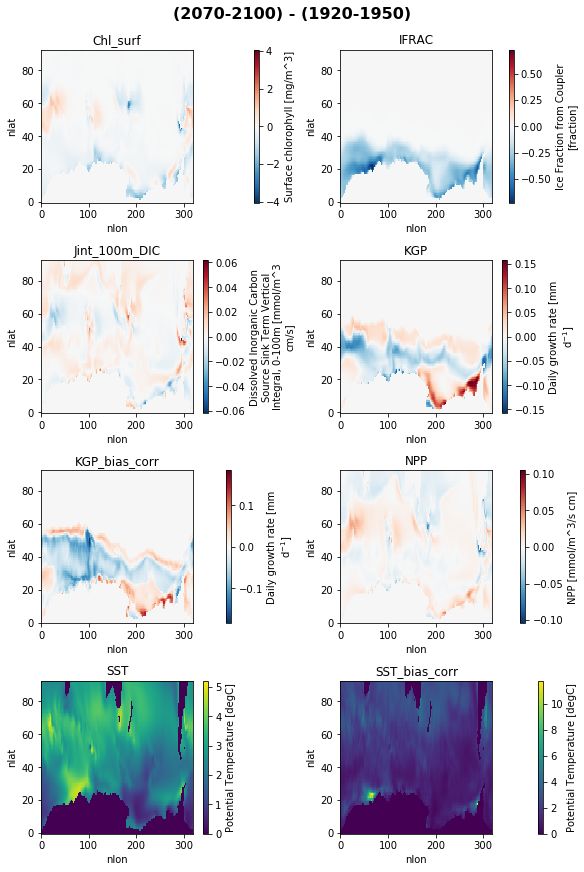

In [19]:
nvar = len(ds_djf_epoch_diff.data_vars)
ncol = int(np.sqrt(nvar))
nrow = int(nvar/ncol) + min(1, nvar%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, v in enumerate(ds_djf_epoch_diff.data_vars):
    plt.axes(ax.ravel()[i])

    with xr.set_options(keep_attrs=True):             
        var = ds_djf_epoch_diff[v].mean('member_id')
    if 'length' in var.dims:
        var = var.sel(length=40.)            
    var.plot()
    plt.title(v)

epoch = ds_djf_epoch.epoch.data
plt.suptitle(f'({epoch[1]}) - ({epoch[0]})', fontsize=16, fontweight='bold');